# Creating the hotspot field from a volume of Level2 data
>##  You can download Level2 data from:
      https://registry.opendata.aws/noaa-nexrad/
      -or-
      https://noaa-nexrad-level2.s3.amazonaws.com/index.html

      There are other archives if this one does not work for you

In [13]:
#include some useful things
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as dt
import numpy as np
import pyart

In [14]:
#
#Use the data supplied in the github repository
#
from config import _EXAMPLEDATA_DIR

filename = Path(_EXAMPLEDATA_DIR, "nexrad_level2", "KFDR20200522_220109_V06") #-10C height = 5713

#filename = Path(_EXAMPLEDATA_DIR, "nexrad_level2", "KFDR_case_KFDR20200522/KFDR20200522_231235_V06") #-10C height = 5713
#filename = Path(_EXAMPLEDATA_DIR, "nexrad_level2", "KOAX20140603_213649_V06.gz") #-10C height = 5188
target_cappi_height = 5713

In [15]:
#
#read in the data, we use pyart, for this,
#but I think that this is the only part of pyart we use.
#We prefer xarray and xarray datasets for faster processing
#
radar_vol = pyart.io.read_nexrad_archive(filename)

In [16]:
#
#select the sweeps (elevations) in the data that we want
#to use in the computation of the hotspot field
#
from prepro.nexrad import prune_nexrad
#we want to use the survalence data and only a volumes worth
#we don't want the doppler cut data nor the extra sweeps from
#SAILS or Meso-Sails
prune_actions = ['surv', 'volume']
prune_vol = prune_nexrad(prune_actions, radar_vol)

In [17]:
#run the radar data through a preproccessor that
#operates similarly to the United Statues NWS ORPG
#
from prepro.nexrad import preprocessor_norpg_xarray
metadata = {}
metadata['zdr_absolute_calibration'] = 0.0
metadata['z_absolute_calibration'] = 0.0
processed_vol = preprocessor_norpg_xarray(prune_vol, metadata)


In [18]:
# get the circular depolarization ratio and add it to the radar object
dr = pyart.retrieve.compute_cdr(processed_vol,
                                     rhohv_field='cross_correlation_ratio',
                                     zdr_field='differential_reflectivity')
processed_vol.add_field('dr', dr)



In [19]:
#add the dualpol processed fields to the pyart object
prepro_dr = pyart.retrieve.compute_cdr(processed_vol,
                                       rhohv_field='prepro_cc',
                                       zdr_field='prepro_zdr')

processed_vol.add_field('prepro_dr', prepro_dr)

In [20]:
#
#move the radials of data into an indexed_vv where the same azimuth(deg) is located at the same index(i)
#this can reduce the resolution of data collected at 0.5 azimuthal intervals to 1.0 degree azimuthal intervals.
#
from cappi.make_vv import get_indexed_vv
indexed_vv = get_indexed_vv(processed_vol)


2024-12-03 11:16:58,270 [MainThread  ] [INFO ]  1 of 14 current_elev: 0.48
2024-12-03 11:16:58,430 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-12-03 11:16:58,430 [MainThread  ] [INFO ]  2 of 14 current_elev: 0.88
2024-12-03 11:16:58,587 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-12-03 11:16:58,587 [MainThread  ] [INFO ]  3 of 14 current_elev: 1.32
2024-12-03 11:16:58,739 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-12-03 11:16:58,740 [MainThread  ] [INFO ]  4 of 14 current_elev: 1.80
2024-12-03 11:16:58,874 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-12-03 11:16:58,875 [MainThread  ] [INFO ]  5 of 14 current_elev: 2.42
2024-12-03 11:16:59,010 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, num_gates: 1200
2024-12-03 11:16:59,010 [MainThread  ] [INFO ]  6 of 14 current_elev: 3.12
2024-12-03 11:16:59,144 [MainThread  ] [INFO ]  num_sweeps: 14, num_azs: 360, nu

In [21]:
# make azran CAPPI interpolation at the sepcified height from the indexed vitual volume
from cappi.azran import indexed_vv_to_cappi_amsl
#input at the top. this changes for each case.
#target_cappi_height = 5713  # m AMSL = -10°C isotherm height, !CASE SPECIFIC!
azran_ds = indexed_vv_to_cappi_amsl(indexed_vv, target_cappi_height)


2024-12-03 11:17:00,871 [MainThread  ] [INFO ]  reminder: using AMSL for target CAPPI height


In [22]:
from cappi.xy_cappi import azran_to_xy
#make xy interpolation and convert to xarray
#We choose to work on a grid that is 400x400 at 1km resolution
x_trg = np.arange(-200, 201)
y_trg = np.arange(-200, 201)
xycappi = azran_to_xy(azran_ds, x_trg, y_trg, max_dist=2)


In [23]:
#Now we create the specific data needed for the hotspot algorithm
import hotspots.detection

#These are hotspots created from the raw radar data. (without expensive preprocessing)

# get hotspot field and detections for unprocessed fields
zdrcut = hotspots.detection.get_filtered_zdr(
        xycappi, refl_fieldname='reflectivity',
        zdr_fieldname='differential_reflectivity',
        cdr_fieldname='dr')

xycappi["zdr_cut"] = zdrcut

hotspot_field, hotspot_features = (
        hotspots.detection.apply_hotspot_method(
        xycappi, x_dim="x", y_dim="y", refl_fieldname='reflectivity',
        zdr_fieldname='zdr_cut'))



In [24]:
#these are the hotspots created from the processed radar data
#similar too the Untied States NWS ORPG 
#
# same for processed radar fields
zdrcut_proc = hotspots.detection.get_filtered_zdr(
        xycappi, refl_fieldname='prepro_zh', zdr_fieldname='prepro_zdr',
        cdr_fieldname='prepro_dr')

xycappi["zdr_cut_proc"] = zdrcut_proc

hotspot_field_proc, hotspot_features_proc = (
        hotspots.detection.apply_hotspot_method(
        xycappi, x_dim="x", y_dim="y", refl_fieldname='prepro_zh',
        zdr_fieldname='zdr_cut_proc'))

#add the hotspot detections as integers
xycappi["hotspot_field_proc"] = hotspot_field_proc

#hotspot features work best when the "missing" or no data is -1 not zero
# easy to fix....
hotspot_features_proc = hotspot_features_proc.where(hotspot_features_proc > 0, -1)
xycappi["hotspot_features_proc"] = hotspot_features_proc.astype(int)




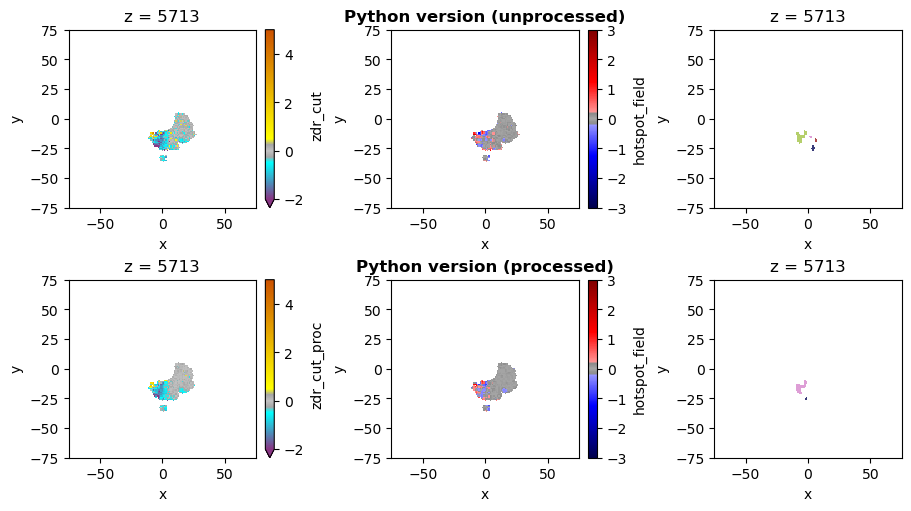

In [25]:
#Plot the results:
# now let's take a look at the output
import klaus_krause_cmap

xlim = (-75, 75)
ylim = (-75, 75)
hs_cmap = klaus_krause_cmap.get_hs_cmap(3)
zdr_cmap = klaus_krause_cmap.get_zdr_cmap(-2, 5)

fig, axs = plt.subplots(2, 3, figsize=(9, 5), constrained_layout=True)
# unprocessed fields
ax1 = axs[0, 0]
xycappi['zdr_cut'].plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap=zdr_cmap, ax=ax1, vmin=-2,
    vmax=5)

ax2 = axs[0, 1]
hotspot_field.plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap=hs_cmap, vmin=-3,
                   vmax=3, ax=ax2)
ax2.set_title('Python version (unprocessed)', fontweight='bold')

ax3 = axs[0, 2]
hotspot_features.where(hotspot_features > 0).plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap='tab20b', add_colorbar=False,
    ax=ax3)
# new hotspots first
ax4 = axs[1, 0]
xycappi['zdr_cut_proc'].plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap=zdr_cmap, ax=ax4, vmin=-2,
    vmax=5)

ax5 = axs[1, 1]
hotspot_field_proc.plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap=hs_cmap,
                        vmin=-3, vmax=3, ax=ax5)
ax5.set_title('Python version (processed)', fontweight='bold')

ax6 = axs[1, 2]
hotspot_features_proc.where(hotspot_features_proc > 0).plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap='tab20b', add_colorbar=False,
    ax=ax6)





In [26]:
xycappi

<xarray.Dataset>
Dimensions:                     (y: 401, x: 401)
Coordinates:
    z                           int64 5713
  * x                           (x) int64 -200 -199 -198 -197 ... 198 199 200
  * y                           (y) int64 -200 -199 -198 -197 ... 198 199 200
    lon                         (x) float64 -101.1 -101.1 ... -96.76 -96.75
    lat                         (y) float64 32.54 32.55 32.56 ... 36.13 36.14
Data variables: (12/21)
    cross_correlation_ratio     (y, x) float64 nan nan nan nan ... nan nan nan
    differential_phase          (y, x) float64 nan nan nan nan ... nan nan nan
    velocity                    (y, x) float64 nan nan nan nan ... nan nan nan
    differential_reflectivity   (y, x) float64 nan nan nan nan ... nan nan nan
    reflectivity                (y, x) float64 nan nan nan nan ... nan nan nan
    spectrum_width              (y, x) float64 nan nan nan nan ... nan nan nan
    ...                          ...
    dr                          (y, x) float64 nan nan nan nan ... nan nan nan
    prepro_dr                   (y, x) float64 nan nan nan nan ... nan nan nan
    zdr_cut                     (y, x) float64 nan nan nan nan ... nan nan nan
    zdr_cut_proc                (y, x) float64 nan nan nan nan ... nan nan nan
    hotspot_field_proc          (y, x) float64 nan nan nan nan ... nan nan nan
    hotspot_features_proc       (y, x) int64 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1
Attributes:
    radar_name:       KFDR
    radar_latitude:   34.3621940612793
    radar_longitude:  -98.97666931152344
    radar_altitude:   400.0
    vcp_pattern:      212
    missing_value:    -9999.0

In [27]:
#
#Assume we are working on the PreProcessed data only
#create hotspot celldata
from stormcell.StormcellXY import LocXY, Stormcell
###
#setup the input to the object definintion function
###
object_ds = xycappi[['hotspot_features_proc', 'hotspot_field_proc']]

obj_ds = object_ds.rename({'hotspot_features_proc':'obj', 'hotspot_field_proc':'data'})
print(obj_ds)

<xarray.Dataset>
Dimensions:  (y: 401, x: 401)
Coordinates:
    z        int64 5713
  * x        (x) int64 -200 -199 -198 -197 -196 -195 ... 195 196 197 198 199 200
  * y        (y) int64 -200 -199 -198 -197 -196 -195 ... 195 196 197 198 199 200
    lon      (x) float64 -101.1 -101.1 -101.1 -101.1 ... -96.77 -96.76 -96.75
    lat      (y) float64 32.54 32.55 32.56 32.57 ... 36.11 36.12 36.13 36.14
Data variables:
    obj      (y, x) int64 -1 -1 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1 -1
    data     (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    radar_name:       KFDR
    radar_latitude:   34.3621940612793
    radar_longitude:  -98.97666931152344
    radar_altitude:   400.0
    vcp_pattern:      212
    missing_value:    -9999.0


In [28]:
from stormcell.stormcell_helpers import create_stormcell_list

hotspot_object_list = create_stormcell_list(obj_ds['obj'], obj_ds['data'])

In [29]:
from stormcell.stormcell_helpers import print_stormcell_list

print_stormcell_list(hotspot_object_list)


1 size: 5.0 max: 0.6643322706222534 loc: -2,-26
2 size: 54.0 max: 1.539147138595581 loc: -8,-13


In [30]:
#
#now we need to make MCIT data and get an MCIT object list.
#
from mcit.vil import get_vil_from_azran
vil = get_vil_from_azran(indexed_vv['reflectivity'])
vil.attrs.update(indexed_vv.attrs)
vil_xy = azran_to_xy(vil, x_trg, y_trg)

In [31]:
from mcit.mcit_objects import mcit_objects, mcit_trim
mcit_raw = mcit_objects(vil_xy, 2.0, 1.25)
mcit_final = mcit_trim(mcit_raw, vil_xy, 5.0, 50)

In [32]:
mcit_final

<xarray.DataArray 'MCIT' (y: 401, x: 401)>
array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])
Coordinates:
  * x        (x) int64 -200 -199 -198 -197 -196 -195 ... 195 196 197 198 199 200
  * y        (y) int64 -200 -199 -198 -197 -196 -195 ... 195 196 197 198 199 200
    lon      (x) float64 -101.1 -101.1 -101.1 -101.1 ... -96.77 -96.76 -96.75
    lat      (y) float64 32.54 32.55 32.56 32.57 ... 36.11 36.12 36.13 36.14

In [33]:
MCIT_object_list = create_stormcell_list(mcit_final, vil_xy)
print_stormcell_list(MCIT_object_list)

1 size: 280.0 max: 18.297452587756123 loc: 1,-17
3 size: 71.0 max: 11.39448988102615 loc: 5,-6


In [34]:
#
#Do hotspot assignment to MCIT Cells (ColumnDepth/MCIT_AssignUpdraft.cpp)
#   so the c++ assignment code uses the previous MCIT cells (t-1) location to do 
#   the assignment to the hotspot at time t. Hmmmmm I guess we'll just match time t
#   time t-1 would require MCIT tracking as well and I don't have that python yet. 
#   Vincent start here... Match MCIT objects with Hotspot objects and combine and trim the 
#   unneeded/unneccessary hotspot objects. We can create the objects from a prvious timestep
#   later if it's important. 
#

In [35]:
from hotspots.assignment import *
merge_dict = hotspot_assignment(MCIT_object_list, hotspot_object_list) 

mcit id 1 size: 280
assigning to MCIT ID 1 (size 280.0): Hotspot ID 2 (size 54.0)
mcit id 3 size: 71


In [36]:
#trim:
assigned_hotspots = filter_assigned_hotspots(obj_ds['obj'],merge_dict)

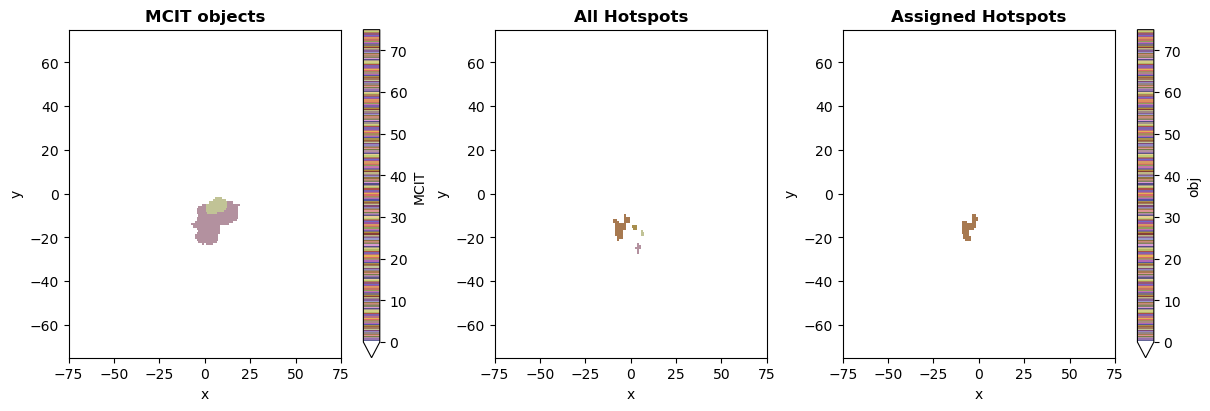

In [37]:
#plot
obj_cmap = klaus_krause_cmap.get_obj_cmap()
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

ax1 = axs[0]
mcit_final.plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap=obj_cmap, ax=ax1, vmin=0,
    vmax=75)
ax1.set_title('MCIT objects', fontweight='bold')

ax2 = axs[1]
hotspot_features.where(hotspot_features > 0).plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap=obj_cmap, add_colorbar=False,
    ax=ax2, vmin=0, vmax=75)
ax2.set_title('All Hotspots', fontweight='bold')

ax3 = axs[2]
assigned_hotspots.plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap=obj_cmap, vmin=0,
                   vmax=75, ax=ax3)
ax3.set_title('Assigned Hotspots', fontweight='bold')

plt.show()

Text(0.5, 1.0, 'VIL with assigned Hotspots')

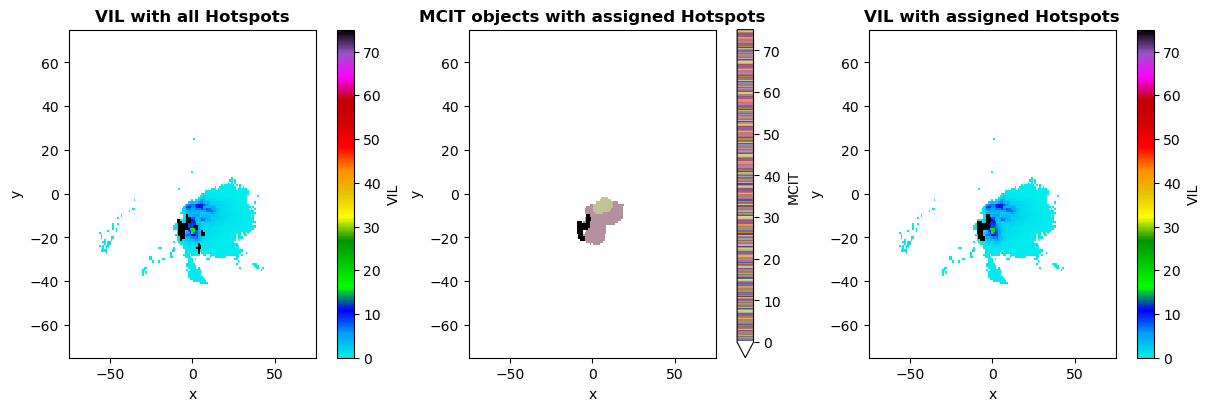

In [38]:
#plot
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


# Create a color map that is just black
black_cmap = ListedColormap(['black'])
#black_cmap.set_under( list(0,0,0,0))
# Define the bounds and normalization
#bounds = [-100000, 0, 10000]
#norm = plt.Normalize(vmin=-1000, vmax=1000)


obj_cmap = klaus_krause_cmap.get_obj_cmap()
fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

ax1 = axs[0]
vil_xy.plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap='pyart_NWSRef', vmin=0, vmax=75, ax=ax1)
hotspot_features.where(hotspot_features > 0).plot(
    x="x", y="y", xlim=xlim, ylim=ylim, cmap=black_cmap, add_colorbar=False,
    ax=ax1, vmin=0, vmax=75)
ax1.set_title('VIL with all Hotspots', fontweight='bold')

ax2 = axs[1]
mcit_final.plot( x="x", y="y", xlim=xlim, ylim=ylim, cmap=obj_cmap, ax=ax2, vmin=0, vmax=75)
assigned_hotspots.where(assigned_hotspots>0.25).plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap=black_cmap, vmin=-1,
                   vmax=75, ax=ax2,add_colorbar=False )
ax2.set_title('MCIT objects with assigned Hotspots', fontweight='bold')





ax3 = axs[2]
vil_xy.plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap='pyart_NWSRef', vmin=0, vmax=75, ax=ax3)
assigned_hotspots.where(assigned_hotspots>0.25).plot(x="x", y="y", xlim=xlim, ylim=ylim, cmap=black_cmap, vmin=-1,
                   vmax=75, ax=ax3, add_colorbar=False)
ax3.set_title('VIL with assigned Hotspots', fontweight='bold')